## Workflow for scATAC-Seq data

If you haven't already then we highly recommend that you please go the {ref}`Workflow for scRNA-Seq analysis <scrna_seq_workflow>` and also go through {ref}`this vignette <data_organization>` describing data organization and design principles of Scarf.

Here we will go through some of the basic steps of analysis of single-cell ATAC-seq (Assay for Transposase-Accessible Chromatin using sequencing) data.

In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.23.0'

time: 2.08 s (started: 2022-09-12 02:15:34 +02:00)


---
### 1) Fetch and convert data

We will use 10x Genomics's singel-cell ATAC-Seq data from peripheral blood mononuclear cells. Like single-cell RNA-Seq, Scarf only needs a count matrix to start the analysis of scATAC-Seq data. We can use `fetch_dataset` to download the data in 10x's HDF5 format.

In [2]:
scarf.fetch_dataset(
    dataset_name='tenx_10K_pbmc-v1_atacseq',
    save_path='scarf_datasets'
)

time: 13.2 s (started: 2022-09-12 02:15:37 +02:00)


The `CrH5Reader` class provides access to the HDF5 file. We can load the file and quickly check the number of features, and also verify that Scarf identified the assay as an ATAC assay. 

In [3]:
reader = scarf.CrH5Reader(
    'scarf_datasets/tenx_10K_pbmc-v1_atacseq/data.h5'
)
reader.assayFeats

,ATAC
type,Peaks
start,0
end,89796
nFeatures,89796


time: 94 ms (started: 2022-09-12 02:15:50 +02:00)


In [4]:
writer = scarf.CrToZarr(
    reader,
    zarr_fn=f'scarf_datasets/tenx_10K_pbmc-v1_atacseq/data.zarr',
    chunk_size=(1000, 2000)
)
writer.dump(batch_size=1000)

  0%|                                                                                                         …

time: 20.4 s (started: 2022-09-12 02:15:50 +02:00)


---
### 2) Create DataStore and filter cells

We load the Zarr file on using `DataStore` class. The obtained `DataStore` object will be our single point on interaction for rest of this analysis. When loaded, Scarf will automatically calculate the number of cells where each peak is present and number of peaks that are accessible in cell (nFeatures). Scarf will also calculate the total number of fragments/cut sites within each cell.

In [5]:
ds = scarf.DataStore(
    'scarf_datasets/tenx_10K_pbmc-v1_atacseq/data.zarr', 
    nthreads=4
)

(ATAC) Computing nCells and dropOuts:   0%|                                                                   …

(ATAC) Computing nCounts:   0%|                                                                               …

(ATAC) Computing nFeatures:   0%|                                                                             …

time: 7.16 s (started: 2022-09-12 02:16:10 +02:00)


We will use `auto_filter_cells` method which automatically remove outliers from the data. To identify outliers we generate a normal distribution using sample mean and variance. Using this normal distribution Scarf estimates the values with probability less 0.01 (default value) on both ends of the distribution and flags them for removal.

INFO: 247 cells flagged for filtering out using attribute ATAC_nCounts
INFO: 294 cells flagged for filtering out using attribute ATAC_nFeatures


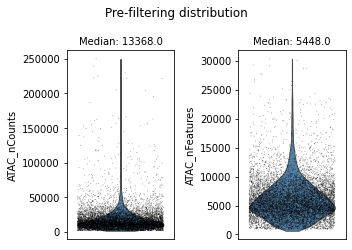

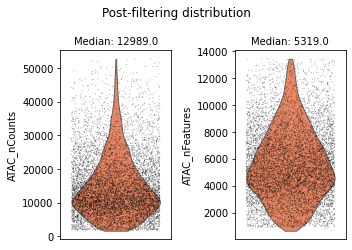

time: 2.02 s (started: 2022-09-12 02:16:17 +02:00)


In [6]:
ds.auto_filter_cells()

---
### 3) Feature selection

For scATAC-Seq data, the features are ranked by their [TF-IDF](https://en.wikipedia.org/wiki/Tf-idf) normalized values, summed across all cells. The top n features are marked as `prevalent_peaks` and are used for downstream steps. Here we used top 25000 peaks, which makes for more than quarter of all the peaks which inline with the what has been suggested in other scATAC-Seq analysis protocols.

In [7]:
ds.mark_prevalent_peaks(top_n=25000)

(ATAC) Calculating peak prevalence across cells:   0%|                                                        …

time: 8.34 s (started: 2022-09-12 02:16:20 +02:00)


In [8]:
ds.ATAC.feats.head()

,I,ids,names,I__prevalent_peaks,dropOuts,nCells,stats_I_prevalence
0,True,chr1:565107-565550,chr1:565107-565550,False,8645,83,0.206181
1,True,chr1:569174-569639,chr1:569174-569639,False,8529,199,0.350725
2,True,chr1:713460-714823,chr1:713460-714823,True,6242,2486,1.993573
3,True,chr1:752422-753038,chr1:752422-753038,True,8296,432,0.680701
4,True,chr1:762106-763359,chr1:762106-763359,True,6850,1878,1.570790


time: 47 ms (started: 2022-09-12 02:16:28 +02:00)


---
### 4) KNN graph creation

For scATAC-Seq datasets, Scarf uses TF-IDF normalization. The normalization is automatically performed during the graph building step. The selected features, marked as `prevalent_peaks` in feature metadata, are used for graph creation. For the dimension reduction step, LSI (latent semantic indexing) is used rather than PCA. The rest of the steps are same as for scRNA-Seq data.

LSI reduction of scATAC-Seq is known to capture the sequencing depth of cells in the first LSI dimension. Hence, by default, the `lsi_skip_first` parameter is True but users can override it.

In [9]:
ds.make_graph(
    feat_key='prevalent_peaks',
    k=21,
    dims=50,
    n_centroids=100,
    lsi_skip_first=True,
)

Writing data to normed__I__prevalent_peaks/data:   0%|                                                        …

Fitting LSI model:   0%|                                                                                      …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.54%
time: 2min 56s (started: 2022-09-12 02:16:28 +02:00)


---
### 5) UMAP reduction and clustering


Non-linear dimension reduction using UMAP and tSNE are performed in the same way as for scRNA-Seq data. Because, in Scarf the core UMAP step are run directly on the neighbourhood graph, the scATAC-Seq data is handled similar to any other data.

In [10]:
ds.run_umap(
    n_epochs=500,
    min_dist=0.1, 
    spread=1, 
    parallel=True
)

Training UMAP:   0%|                                                                                          …

time: 21.6 s (started: 2022-09-12 02:19:24 +02:00)


Same goes for clustering as well. The leiden clustering acts on the neighbourhood graph directly.

In [11]:
ds.run_leiden_clustering(resolution=0.6)

time: 641 ms (started: 2022-09-12 02:19:46 +02:00)


Results from both UMAP and Leiden clustering are stored in cell attribute table. Here, because the UMAP and leiden clustering columns have 'ATAC' prefixes because they were executed on the default 'ATAC' assay. You can also see that the cells that were filtered out (marked by 'False' value in column 'I') have NaN value for UMAP axes and -1 for clustering

In [12]:
ds.cells.head()

,I,ids,names,ATAC_UMAP1,ATAC_UMAP2,ATAC_leiden_cluster,ATAC_nCounts,ATAC_nFeatures
0,True,AAACGAAAGAGCGAAA-1,AAACGAAAGAGCGAAA-1,0.273762,14.568570,1,13187.0,5546.0
1,True,AAACGAAAGAGTTTGA-1,AAACGAAAGAGTTTGA-1,1.261916,17.095806,4,16074.0,6586.0
2,True,AAACGAAAGCGAGCTA-1,AAACGAAAGCGAGCTA-1,-0.372150,-9.112377,3,28009.0,9214.0
3,False,AAACGAAAGGCTTCGC-1,AAACGAAAGGCTTCGC-1,NaN,NaN,-1,221747.0,30325.0
4,True,AAACGAAAGTGCTGAG-1,AAACGAAAGTGCTGAG-1,-0.131319,14.212608,1,11440.0,4922.0


time: 47 ms (started: 2022-09-12 02:19:47 +02:00)


We can visualize the UMAP embedding and the clusters of cells on the embedding

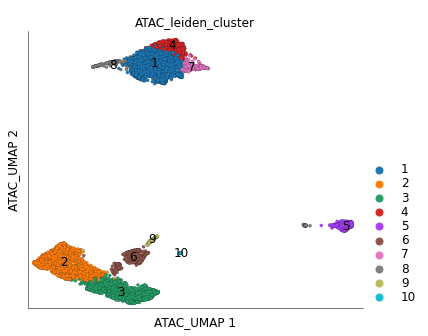

time: 484 ms (started: 2022-09-12 02:19:47 +02:00)


In [13]:
ds.plot_layout(
    layout_key='ATAC_UMAP', 
    color_by='ATAC_leiden_cluster'
)

Those familiar with PBMC datasets might already be able to identify different cell types in the UMAP plot.

---
### 6) Calculating gene scores

The features in snATAC-Seq in form of peak coordinates are hard to interpret by themselves.
Hence, distilling the open chromatin regions in terms of accessible genes can help in identification of cell types.
`GeneScores` are simply the summation of all the peak fragments that are present within gene bodies and their corresponding promoter region.
Since, marker genes are often better understood than the non-coding regions the `GeneScores` can be used to annotate cell types.

In Scarf, the users can provide a BED file containing gene annotations. This BED should have no header, should be tab separated and must have the columns in following order:
1) chromosome identifier
2) start coordinate
3) end coordinate 
4) Gene ID
5) Gene Name
6) Strand (Optional)

The start/end coordinate can extend through transcription start site (TSS) to include a portion of promoter.

For convenience we have generated such BED files for human and mouse assemblies using the annotation information from GENCODE project. We downloaded the GFF3 format primary chromosome annotations and used Scarf's `GFFReader` to convert the files into BED and add promoter offset of 2KB. These BED files containing gene annotations can be downloaded using `fetch_dataset` command and passing 'annotations' parameter.

In [14]:
scarf.fetch_dataset(
    dataset_name='annotations', 
    save_path='scarf_datasets'
)

time: 9.91 s (started: 2022-09-12 02:19:47 +02:00)


----

Now we have the annotations and are ready to calculate the 'GeneScores'. The `add_melded_assay` is the `DataStore` method that will be used for this purpose. The `add_melded_assay` method is actually designed to map any arbitrary genomic coordinate information (not just gene annotations) to the ATAC peaks. Here, we use the term 'melding' for the process wherein for a given loci the values from all the overlapping peaks are merged/melded into that feature. The peaks values are TF-IDF normalized before melding.

Now we explain the parameters that are usually passed to the `add_melded_assay`.
- `from_assay`: Name of the assay to be acted on. You can generally skip if you have only one assay. We use this parameter here only for demonstration puspose
- `external_bed_fn`: This is the annotation file. Here we pass the annotation for human GRCh37/hg19 assembly based GENCODE v38 annotations.
- `peak_col`: This is the column in `ds.ATAC.feats` table that contains the peak coordinates. In this case it is 'ids', but could be anyt other column. Please note that the coordinate information in this column should be in format 'chr:start-end' (please note the positions of colon and hyphen)
- `renormalization`: By overriding the default value of True to False here, we turned off 'renormalization' step. The renormalization step makes sure that all the feature values for each cells in the melded assay sum up to the same value. Here we turned this off because we will have 'GeneScores' as an 'RNAassay' which uses library size normalization that has the same effect as 'renormalization'.
- `assay_label`: The label/name of the melded/output assay. Because we are using gene bodies as our input, 'GeneScores' is sensible choice.
- `assay_type`: Here we set the type of assay as 'RNA' which means that the new melded assay will be treated as if it was an scRNA-Seq assay. Alternatively, we could have set it as a generic 'Assay'

In [15]:
ds.add_melded_assay(
    from_assay='ATAC',
    external_bed_fn='scarf_datasets/annotations/human_GRCh37_gencode_v38_gene_body.bed.gz',
    peaks_col='ids',
    renormalization=False,
    assay_label='GeneScores',
    assay_type='RNA'
)

INFO: 33898/62409 features did not overlap with any peak


  0%|                                                                                                         …

(GeneScores) Computing nCells and dropOuts:   0%|                                                             …

(GeneScores) Computing nCounts:   0%|                                                                         …

(GeneScores) Computing nFeatures:   0%|                                                                       …

(GeneScores) Computing GeneScores_percentMito:   0%|                                                          …

(GeneScores) Computing GeneScores_percentRibo:   0%|                                                          …

time: 2min 32s (started: 2022-09-12 02:19:57 +02:00)


---

We can now print out the DataStore and see that the 'GeneScores' assay has indeed been added. The 'add_melded_assay' also printed a useful bit of information that almost half of features(genes bodies) did not overlap with even a single peak. The melded assay anyway contains all the genes but sets these 'empty' genes as invalid.

In [16]:
ds

DataStore has 8426 (8728) cells with 2 assays: ATAC GeneScores
   Cell metadata:
            'I', 'ids', 'names', 'ATAC_UMAP1', 'ATAC_UMAP2', 
            'ATAC_leiden_cluster', 'ATAC_nCounts', 'ATAC_nFeatures', 'GeneScores_nCounts', 'GeneScores_nFeatures', 
            'GeneScores_percentMito', 'GeneScores_percentRibo'
   ATAC assay has 86049 (89796) features and following metadata:
            'I', 'ids', 'names', 'I__prevalent_peaks', 'dropOuts', 
            'nCells'
   GeneScores assay has 28357 (62409) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          

time: 47 ms (started: 2022-09-12 02:22:30 +02:00)


Let's now visualize some 'GeneScores' for some of the known marker genes for PBMCs on the UMAP plot calculated on the ATAC assay

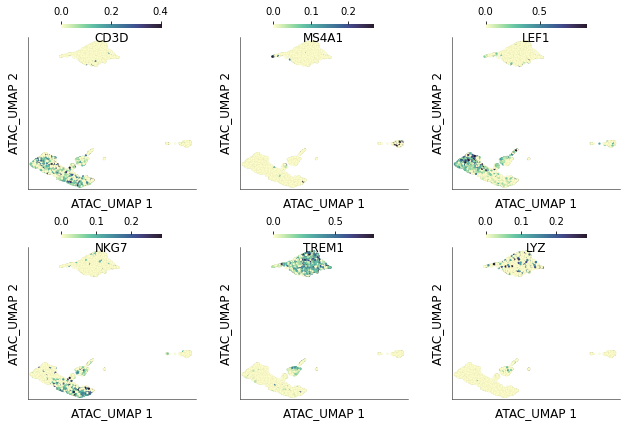

time: 10.3 s (started: 2022-09-12 02:22:30 +02:00)


In [17]:
ds.plot_layout(
    layout_key='ATAC_UMAP', from_assay='GeneScores', 
    color_by=['CD3D', 'MS4A1', 'LEF1', 'NKG7', 'TREM1', 'LYZ'],
    clip_fraction=0.01, 
    n_columns=3,
    width=3,
    height=3,
    point_size=5,
    scatter_kwargs={'lw': 0.01},
)

We stop here in this vignette. But will soon add other vignettes that show how we can other kinds of melded assays like motifs, enhancers, etc. We will also explore how we can use the 'GeneScores' to integrate scATAC-Seq datasets with scRNA-Seq datasets from same population of cells (but not the exact same set of cells)

---
That is all for this vignette.